In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
from deep_translator import GoogleTranslator

from tqdm import tqdm

plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from LeIA import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from google_play_scraper import Sort, reviews, app

In [64]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/raycalm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [65]:
apps_ids = ['br.com.brainweb.ifood', 'com.cerveceriamodelo.modelonow',

'com.mcdo.mcdonalds', 'habibs.alphacode.com.br',

'com.ubercab.eats', 'com.grability.rappi',

'burgerking.com.br.appandroid', 

'com.vanuatu.aiqfome',

'br.com.sbf.centauro',

'br.com.riachuelo.app',

'com.mercadolibre',

'com.cerveceriamodelo.modelonow',

'com.amazon.mShop.android.shopping',

'br.gov.meugovbr',

'com.b2w.americanas',

'br.com.lojasrenner',

'br.com.marisa.android',

'com.zzkko',

'com.luizalabs.mlapp']

In [66]:
apps_reviews = []

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            apps_reviews.extend(rvs)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [01:03<00:00,  3.36s/it]


In [67]:
df = pd.DataFrame(apps_reviews)

In [68]:
df = df.drop(['reviewId'], axis=1)
df['id'] = range(1, len(df) + 1)

In [69]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,Fabiano Porto,https://play-lh.googleusercontent.com/a-/ALV-U...,Já é a segunda vez que tento resolver um probl...,1,34,10.24.0,2024-07-14 15:24:26,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,37,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,34,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,5,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,70,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


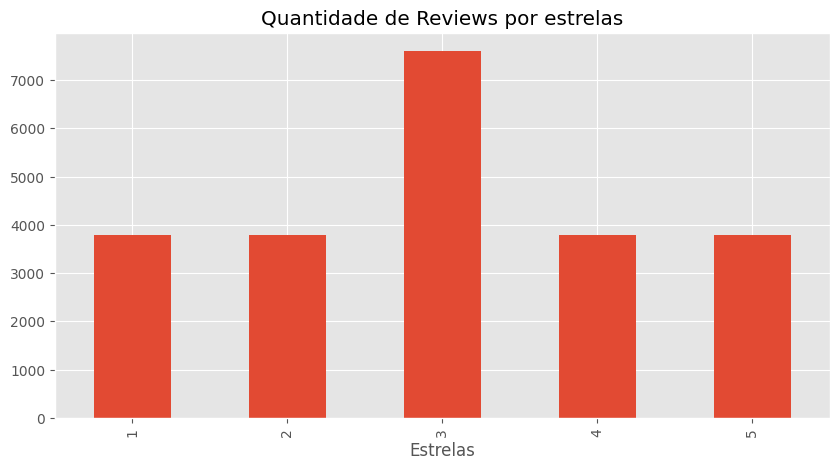

In [70]:
ax = df['score'].value_counts().sort_index().plot(kind='bar', title='Quantidade de Reviews por estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
plt.show()

### NLTK Básico

In [71]:
WORD_MIN_LENGTH = 2
STOP_WORDS_PT = [stop_word.lower() for stop_word in nltk.corpus.stopwords.words('portuguese')]
spell = SpellChecker(language='pt')

def strip_accents(text):
    nfkd = unicodedata.normalize('NFKD', text)
    stripped_text = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub('[^a-zA-Z]', ' ', stripped_text)

def tokenize(text):
    text = strip_accents(text)
    text = re.sub(re.compile('\n'),' ',text)
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if word not in STOP_WORDS_PT and len(word) >= WORD_MIN_LENGTH]
    return words

def lemmatize(text):
    lemmatized_text = []
    for (word) in text:
        lemmatizing = str(WordNetLemmatizer().lemmatize(word))
        lemmatized_text.append(lemmatizing)
    return lemmatized_text

def preprocess_stl(array):
    preprocessed = []

    stripped_rvs = [strip_accents(rvs) for rvs in array]
    tokenized_rvs = [tokenize(rvs) for rvs in stripped_rvs]
    lemmatized_rvs = [lemmatize(rvs) for rvs in tokenized_rvs]

    preprocessed = lemmatized_rvs

    return preprocessed



## Utilizando VADER
Abordagem BoW - removeremos stop words e cada palavra remeterá a uma pontuação e essas pontuações serão combinadas para obter uma pontuação final

In [72]:
sia = SentimentIntensityAnalyzer()
# translator = GoogleTranslator(source='pt', target='en')

In [73]:
# def translate_and_analyze(text, myid):
#     try:
#         translated_text = translator.translate(text)
#         if translated_text is None:
#             raise ValueError("Translation returned None")
#         sentiment = sia.polarity_scores(translated_text)
#         return myid, sentiment
#     except Exception as e:
#         return myid, {"error": str(e)}

In [80]:
# df_sample = df.sample(n=500, random_state=42)

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 22800/22800 [00:16<00:00, 1401.06it/s]


In [81]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,Fabiano Porto,https://play-lh.googleusercontent.com/a-/ALV-U...,Já é a segunda vez que tento resolver um probl...,1,34,10.24.0,2024-07-14 15:24:26,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,37,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,34,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,5,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,70,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


In [82]:
vaders = pd.DataFrame(res).T
vaders.reset_index(inplace=True)
vaders = vaders.rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left', on='id')

In [83]:
vaders = vaders.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)

In [84]:
vaders.head()

,id,neg,neu,pos,compound,content,score,appId
0,1,0.211,0.696,0.093,-0.7160,Já é a segunda vez que tento resolver um probl...,1,br.com.brainweb.ifood
1,2,0.121,0.783,0.096,-0.2023,Um lixo de aplicativo. Cada vez mais a experiê...,1,br.com.brainweb.ifood
2,3,0.109,0.774,0.117,0.1280,O atendimento pelo chat no geral era bom. Hoje...,1,br.com.brainweb.ifood
3,4,0.193,0.783,0.024,-0.8765,Estou bem decepcionado com o app. É cada vez m...,1,br.com.brainweb.ifood
4,5,0.078,0.864,0.058,-0.2732,"Com certeza um dos piores apps que tenho, volu...",1,br.com.brainweb.ifood


In [86]:
vaders = vaders.dropna(subset=['pos', 'neg', 'neu'])

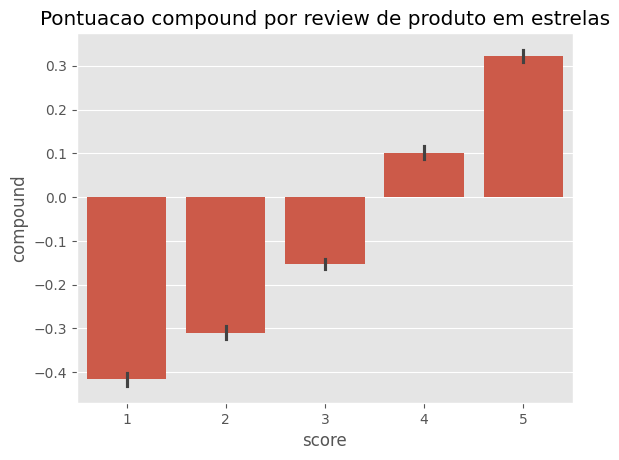

In [88]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Pontuacao compound por review de produto em estrelas')
plt.show()

Quando menor a pontuação compound, menor a quantidade de estrelas dada pelo consumidor.

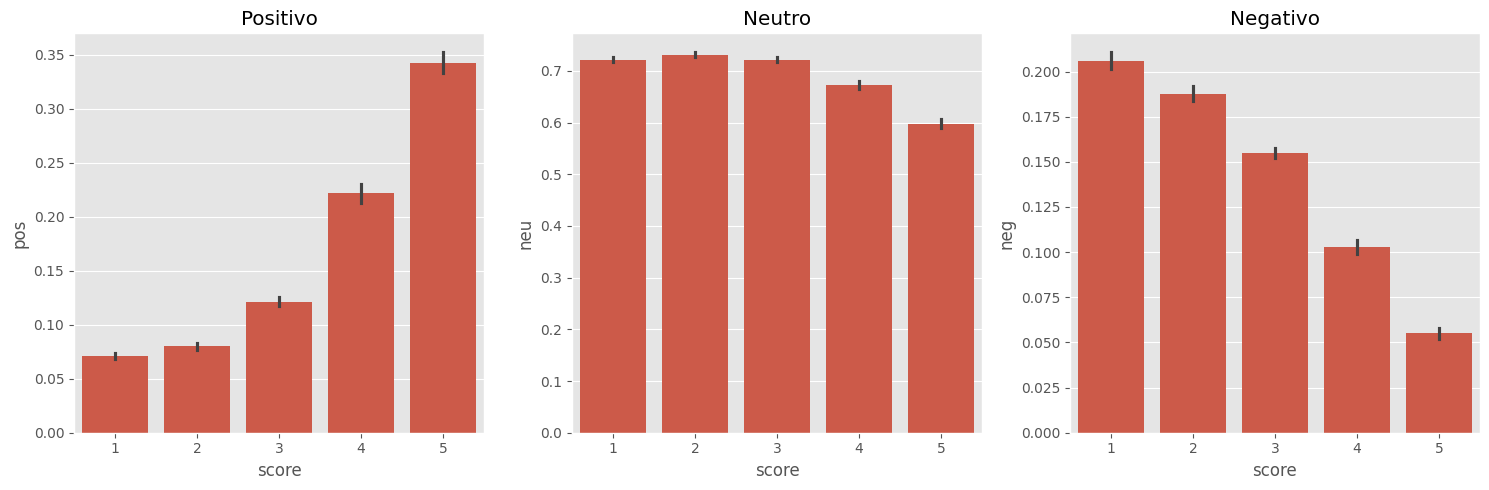

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positivo')
axs[1].set_title('Neutro')
axs[2].set_title('Negativo')

plt.tight_layout()
plt.show()

## Utilizando RoBERTa

In [90]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [91]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [94]:
# Exemplo executado para VADER

example = df['content'][0]
vader_result = sia.polarity_scores(example)

print(example)
print(vader_result)

Já é a segunda vez que tento resolver um problema com uma loja que não responde e a ajuda do Ifood não tem serventia nenhuma. O que me faz acreditar que a plataforma é conivente com a falta de compromisso e descaso com o cliente ao permitir lojas que demoram quase duas horas para entregar um pedido e não entregam. Experiência péssima é pouco para definir o uso do aplicativo.
{'neg': 0.211, 'neu': 0.696, 'pos': 0.093, 'compound': -0.716}


In [93]:
# Executando para o modelo RoBERTa
encoded_text = tokenizer(example, return_tensors='pt')


{'input_ids': tensor([[    0,   863,  1526,  7935,    10,   842,   571, 21729,  5030,   329,
          1192, 10178,   139,  5032, 35934,  7252,   936,   102,  3137,  1717,
          1916,  4600,  1910,  1192,   295,  4214,  2519,   242,   364,    10,
            10, 12864,   102,   109,   318,  5715,   295,  4214, 11030, 18527,
          1342,   493,   295, 15477,  5037,     4,   384,  1192,   162,   856,
          1222,  4285, 35979,   271,  1192,    10,  2968,  2186,  3899,   102,
          7935,  2764,  1879,  8530,  3137,    10,   856,  3967,   102,   263,
         40734,   354,  2527,   364, 23174,   281,   139,  3137,  1021,  3653,
           242,    10,   139,  6687,   853,  4600, 19798,  1192,  4410,   368,
           424,  2677,  3175,  4279,   281, 17211,   281,  3840,  3838,  4950,
           271,  7252, 16954,  6005,   364,   295,  4214,  3838,  4950,   424,
             4, 26403,   118,  5563, 11326,   493,   181,  1140,  7485,  4261,
          7935,   181,  1438,   876,  